# 1. Importing Packages and Collecting Data


In [5]:
'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

'''Import basic modules.'''
import pandas as pd
import numpy as np
from scipy import stats

'''Customize visualization
Seaborn and matplotlib visualization.'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [6]:
'''Read in export and import data from CSV file'''
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [7]:
df_train['Intersection'] = df_train['IntersectionId'].astype(str) + df_train['City']
df_test['Intersection'] = df_test['IntersectionId'].astype(str) + df_test['City']
print(df_train['Intersection'].sample(6).values)

['1717Philadelphia' '1946Chicago' '350Philadelphia' '249Atlanta'
 '219Boston' '1924Philadelphia']


In [8]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
le.fit(pd.concat([df_train['Intersection'], df_test['Intersection']]).drop_duplicates().values)
df_train['Intersection'] = le.transform(df_train['Intersection'])
df_test['Intersection'] = le.transform(df_test['Intersection'])
print(df_train['Intersection'].sample(6).values)

[1358 2051 4541 3884 1443  525]


In [9]:
# Reference: https://www.kaggle.com/bgmello/how-one-percentile-affect-the-others

'''Let's use the following road types: Street, Avenue, Road, Boulevard, Broad and Drive'''
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

In [10]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

In [11]:
df_train['EntryTypeStreet'] = df_train['EntryStreetName'].apply(encode)
df_train['ExitTypeStreet'] = df_train['ExitStreetName'].apply(encode)
df_test['EntryTypeStreet'] = df_test['EntryStreetName'].apply(encode)
df_test['ExitTypeStreet'] = df_test['ExitStreetName'].apply(encode)
print(df_train['EntryTypeStreet'].sample(10).values)

[2 2 2 3 2 2 4 2 2 2]


In [12]:
df_train["same_street_exact"] = (df_train["EntryStreetName"] ==  df_train["ExitStreetName"]).astype(int)
df_test["same_street_exact"] = (df_test["EntryStreetName"] ==  df_test["ExitStreetName"]).astype(int)

In [13]:
'''Defineing the directions'''
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [14]:
df_train['EntryHeading'] = df_train['EntryHeading'].map(directions)
df_train['ExitHeading'] = df_train['ExitHeading'].map(directions)

df_test['EntryHeading'] = df_test['EntryHeading'].map(directions)
df_test['ExitHeading'] = df_test['ExitHeading'].map(directions)

df_train['diffHeading'] = df_train['EntryHeading']- df_train['ExitHeading']  
df_test['diffHeading'] = df_test['EntryHeading']- df_test['ExitHeading']

display(df_train[['ExitHeading','EntryHeading','diffHeading']].drop_duplicates().head(5))

,ExitHeading,EntryHeading,diffHeading
0,1.75,1.75,0.0
1,0.75,0.75,0.0
381,0.75,0.25,-0.5
654,0.75,1.25,0.5
655,0.25,0.75,0.5


In [15]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['City'], drop_first = False)], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['City'], drop_first = False)], axis=1)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
lat_long = ['Latitude', 'Longitude']
for col in lat_long:
    df_train[col] = (scaler.fit_transform(df_train[col].values.reshape(-1, 1)))
    df_test[col] = (scaler.fit_transform(df_test[col].values.reshape(-1, 1)))

In [17]:
"""Let's see the columns of data"""
df_train.columns.values

array(['RowId', 'IntersectionId', 'Latitude', 'Longitude',
       'EntryStreetName', 'ExitStreetName', 'EntryHeading', 'ExitHeading',
       'Hour', 'Weekend', 'Month', 'Path', 'TotalTimeStopped_p20',
       'TotalTimeStopped_p40', 'TotalTimeStopped_p50',
       'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City',
       'Intersection', 'EntryTypeStreet', 'ExitTypeStreet',
       'same_street_exact', 'diffHeading', 'Atlanta', 'Boston', 'Chicago',
       'Philadelphia'], dtype=object)

In [18]:
"""Let's drop the unwanted variables from test and train dataset"""
df_train.drop(['RowId', 'IntersectionId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'], axis=1, inplace=True)
df_test.drop(['RowId', 'IntersectionId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'], axis=1, inplace=True)

# 5. Seting X and Y

In [19]:
"""Let's look at our final train and test data for modelling."""
bold('**Updated train data for modelling:**')
display(df_train.head(3))
bold('**Updated test data for modelling:**')
display(df_test.head(3))

**Updated train data for modelling:**

,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,...,DistanceToFirstStop_p80,Intersection,EntryTypeStreet,ExitTypeStreet,same_street_exact,diffHeading,Atlanta,Boston,Chicago,Philadelphia
0,-1.985159,-1.09417,1.75,1.75,0,0,6,0.0,0.0,0.0,...,0.0,0,4,4,1,0.0,1,0,0,0
1,-1.985159,-1.09417,0.75,0.75,0,0,6,0.0,0.0,0.0,...,0.0,0,4,4,1,0.0,1,0,0,0
2,-1.985159,-1.09417,1.75,1.75,1,0,6,0.0,0.0,0.0,...,0.0,0,4,4,1,0.0,1,0,0,0


**Updated test data for modelling:**

,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,Intersection,EntryTypeStreet,ExitTypeStreet,same_street_exact,diffHeading,Atlanta,Boston,Chicago,Philadelphia
0,-2.032343,-1.091191,0.25,0.25,0,0,6,2602,2,2,1,0.0,1,0,0,0
1,-2.032343,-1.091191,1.25,0.75,0,0,6,2602,2,2,0,0.5,1,0,0,0
2,-2.032343,-1.091191,1.25,1.25,0,0,6,2602,2,2,1,0.0,1,0,0,0


In [20]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [21]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 179.68 MB
Memory usage after optimization is: 45.74 MB
Decreased by 74.5%
Memory usage of dataframe is 183.24 MB
Memory usage after optimization is: 47.64 MB
Decreased by 74.0%


In [22]:
'''Seting X and Y'''
target_var = df_train.iloc[:, 7:22]
X_train = df_train.drop(target_var,axis = 1)

y1_train = df_train["TotalTimeStopped_p20"]
y2_train = df_train["TotalTimeStopped_p50"]
y3_train = df_train["TotalTimeStopped_p80"]
y4_train = df_train["DistanceToFirstStop_p20"]
y5_train = df_train["DistanceToFirstStop_p50"]
y6_train = df_train["DistanceToFirstStop_p80"]

X_test = df_test

In [23]:
"""Let's have a final look at our data"""
bold('**Data Dimension for Model Building:**')
print('Input matrix dimension:', X_train.shape)
print('Output vector dimension:',y1_train.shape)
print('Test data dimension:', X_test.shape)

**Data Dimension for Model Building:**

Input matrix dimension: (856387, 16)
Output vector dimension: (856387,)
Test data dimension: (1921357, 16)


In [24]:
X_train.columns

Index(['Latitude', 'Longitude', 'EntryHeading', 'ExitHeading', 'Hour',
       'Weekend', 'Month', 'Intersection', 'EntryTypeStreet', 'ExitTypeStreet',
       'same_street_exact', 'diffHeading', 'Atlanta', 'Boston', 'Chicago',
       'Philadelphia'],
      dtype='object')

In [25]:
"""pecifying categorical features"""
cat_feat = ['Hour', 'Weekend','Month', 'same_street_exact', 'Intersection',
       'Atlanta', 'Boston', 'Chicago', 'Philadelphia', 'EntryTypeStreet', 'ExitTypeStreet']

rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']
                       

In [26]:
for cf in cat_feat:
    X_train[cf] = X_train[cf].astype(int)
    X_test[cf] = X_test[cf].astype(int)

In [27]:
all_preds ={0:[],1:[],2:[],3:[],4:[],5:[]}
all_target = [y1_train, y2_train, y3_train, y4_train, y5_train, y6_train]

In [28]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
train_set = X_train
test_set = X_test

In [27]:
models = []
for i,tc in enumerate(rel_training_label_cols):
    X_train,X_validation,y_train,y_validation=train_test_split(train_set,all_target[i], test_size=0.2, random_state=31)

    model = CatBoostRegressor(
        loss_function='RMSE',
        iterations=200
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_feat,
        eval_set=(X_validation, y_validation),
    #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True
    )
    models.append(model)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 6.8820235	test: 6.8085650	best: 6.8085650 (0)	total: 203ms	remaining: 40.4s
1:	learn: 6.7445098	test: 6.6571545	best: 6.6571545 (1)	total: 331ms	remaining: 32.8s
2:	learn: 6.6695849	test: 6.5658678	best: 6.5658678 (2)	total: 419ms	remaining: 27.5s
3:	learn: 6.6113448	test: 6.4949000	best: 6.4949000 (3)	total: 497ms	remaining: 24.4s
4:	learn: 6.5779315	test: 6.4550264	best: 6.4550264 (4)	total: 603ms	remaining: 23.5s
5:	learn: 6.5436799	test: 6.4178089	best: 6.4178089 (5)	total: 759ms	remaining: 24.5s
6:	learn: 6.5237098	test: 6.3969001	best: 6.3969001 (6)	total: 870ms	remaining: 24s
7:	learn: 6.5091259	test: 6.3821344	best: 6.3821344 (7)	total: 913ms	remaining: 21.9s
8:	learn: 6.4923500	test: 6.3624637	best: 6.3624637 (8)	total: 1.02s	remaining: 21.6s
9:	learn: 6.4773681	test: 6.3432744	best: 6.3432744 (9)	total: 1.19s	remaining: 22.6s
10:	learn: 6.4623605	test: 6.3260911	best: 6.3260911 (10)	total: 1.35s	remaining: 23.2s
11:	learn: 6.4545322	tes

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 14.5365435	test: 14.4158300	best: 14.4158300 (0)	total: 152ms	remaining: 30.2s
1:	learn: 13.9726792	test: 13.8353591	best: 13.8353591 (1)	total: 264ms	remaining: 26.1s
2:	learn: 13.6253891	test: 13.4576361	best: 13.4576361 (2)	total: 347ms	remaining: 22.8s
3:	learn: 13.4413996	test: 13.2591430	best: 13.2591430 (3)	total: 469ms	remaining: 23s
4:	learn: 13.2939959	test: 13.0951841	best: 13.0951841 (4)	total: 621ms	remaining: 24.2s
5:	learn: 13.2255446	test: 13.0176063	best: 13.0176063 (5)	total: 741ms	remaining: 24s
6:	learn: 13.1759164	test: 12.9634755	best: 12.9634755 (6)	total: 865ms	remaining: 23.8s
7:	learn: 13.0685206	test: 12.8411859	best: 12.8411859 (7)	total: 1s	remaining: 24s
8:	learn: 13.0339913	test: 12.8050918	best: 12.8050918 (8)	total: 1.11s	remaining: 23.6s
9:	learn: 13.0004697	test: 12.7713650	best: 12.7713650 (9)	total: 1.24s	remaining: 23.5s
10:	learn: 12.9581566	test: 12.7347502	best: 12.7347502 (10)	total: 1.37s	remaining: 23.6

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 25.7953854	test: 25.3731517	best: 25.3731517 (0)	total: 148ms	remaining: 29.5s
1:	learn: 24.5731899	test: 24.1294844	best: 24.1294844 (1)	total: 258ms	remaining: 25.5s
2:	learn: 23.9479085	test: 23.4708489	best: 23.4708489 (2)	total: 312ms	remaining: 20.5s
3:	learn: 23.5796444	test: 23.1076325	best: 23.1076325 (3)	total: 435ms	remaining: 21.3s
4:	learn: 23.2624341	test: 22.7478722	best: 22.7478722 (4)	total: 539ms	remaining: 21s
5:	learn: 23.0844981	test: 22.5740190	best: 22.5740190 (5)	total: 629ms	remaining: 20.3s
6:	learn: 22.9404475	test: 22.4235356	best: 22.4235356 (6)	total: 754ms	remaining: 20.8s
7:	learn: 22.8332183	test: 22.3320067	best: 22.3320067 (7)	total: 842ms	remaining: 20.2s
8:	learn: 22.7005951	test: 22.2103672	best: 22.2103672 (8)	total: 968ms	remaining: 20.5s
9:	learn: 22.6278554	test: 22.1362155	best: 22.1362155 (9)	total: 1.07s	remaining: 20.4s
10:	learn: 22.5543056	test: 22.0422504	best: 22.0422504 (10)	total: 1.24s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 28.5722358	test: 28.8458722	best: 28.8458722 (0)	total: 144ms	remaining: 28.7s
1:	learn: 28.1233541	test: 28.3559515	best: 28.3559515 (1)	total: 258ms	remaining: 25.5s
2:	learn: 27.8680315	test: 28.0565389	best: 28.0565389 (2)	total: 350ms	remaining: 23s
3:	learn: 27.7243303	test: 27.9074214	best: 27.9074214 (3)	total: 483ms	remaining: 23.6s
4:	learn: 27.6466559	test: 27.8144424	best: 27.8144424 (4)	total: 594ms	remaining: 23.2s
5:	learn: 27.4354496	test: 27.5827533	best: 27.5827533 (5)	total: 738ms	remaining: 23.9s
6:	learn: 27.3102500	test: 27.4263708	best: 27.4263708 (6)	total: 898ms	remaining: 24.8s
7:	learn: 27.2527213	test: 27.3720150	best: 27.3720150 (7)	total: 1.03s	remaining: 24.8s
8:	learn: 27.1965419	test: 27.2962349	best: 27.2962349 (8)	total: 1.12s	remaining: 23.7s
9:	learn: 27.1256330	test: 27.2060460	best: 27.2060460 (9)	total: 1.27s	remaining: 24.1s
10:	learn: 26.9931800	test: 27.0473548	best: 27.0473548 (10)	total: 1.45s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 71.7767936	test: 72.4846422	best: 72.4846422 (0)	total: 150ms	remaining: 29.8s
1:	learn: 70.3483156	test: 71.0335683	best: 71.0335683 (1)	total: 263ms	remaining: 26s
2:	learn: 69.5734224	test: 70.2064016	best: 70.2064016 (2)	total: 341ms	remaining: 22.4s
3:	learn: 69.0002114	test: 69.8292173	best: 69.8292173 (3)	total: 412ms	remaining: 20.2s
4:	learn: 67.3941162	test: 68.1089873	best: 68.1089873 (4)	total: 526ms	remaining: 20.5s
5:	learn: 67.1299755	test: 67.8593155	best: 67.8593155 (5)	total: 700ms	remaining: 22.6s
6:	learn: 66.6437529	test: 67.2724674	best: 67.2724674 (6)	total: 781ms	remaining: 21.5s
7:	learn: 66.1266538	test: 66.7907639	best: 66.7907639 (7)	total: 927ms	remaining: 22.2s
8:	learn: 65.9037122	test: 66.5898028	best: 66.5898028 (8)	total: 1.03s	remaining: 21.8s
9:	learn: 65.2179267	test: 65.7976979	best: 65.7976979 (9)	total: 1.12s	remaining: 21.3s
10:	learn: 64.7773607	test: 65.3068367	best: 65.3068367 (10)	total: 1.24s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 153.8314881	test: 153.1836350	best: 153.1836350 (0)	total: 149ms	remaining: 29.6s
1:	learn: 150.5252484	test: 149.8728653	best: 149.8728653 (1)	total: 220ms	remaining: 21.8s
2:	learn: 144.3454253	test: 143.5902237	best: 143.5902237 (2)	total: 344ms	remaining: 22.6s
3:	learn: 141.6605115	test: 140.5880791	best: 140.5880791 (3)	total: 449ms	remaining: 22s
4:	learn: 139.6171405	test: 138.2388438	best: 138.2388438 (4)	total: 541ms	remaining: 21.1s
5:	learn: 138.9935613	test: 137.5758631	best: 137.5758631 (5)	total: 659ms	remaining: 21.3s
6:	learn: 138.1120713	test: 136.7420364	best: 136.7420364 (6)	total: 810ms	remaining: 22.3s
7:	learn: 136.4998728	test: 135.0142143	best: 135.0142143 (7)	total: 926ms	remaining: 22.2s
8:	learn: 134.7351465	test: 133.2798562	best: 133.2798562 (8)	total: 1.05s	remaining: 22.3s
9:	learn: 134.3861887	test: 132.9707502	best: 132.9707502 (9)	total: 1.21s	remaining: 23s
10:	learn: 133.4040475	test: 131.9145645	best: 131.914

In [30]:
import pickle
import pandas as pd
import numpy as np

In [29]:
# with open('models.pickle', 'wb') as handle:
#     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('models.pickle', 'rb') as handle:
    models = pickle.load(handle)

In [36]:
preds = []
truths = []
for i in range(6):
    X_train,X_validation,y_train,y_validation=train_test_split(train_set,all_target[i], test_size=0.2, random_state=31)
    preds.append(models[i].predict(X_validation))
    truths.append(y_validation.values)

In [38]:
preds = np.concatenate(preds)
truths = np.concatenate(truths)

In [40]:
np.sqrt(((preds - truths) ** 2).mean())

50.455332345134565

In [3]:
df_test = pd.read_csv('../data/test.csv')

In [4]:
df = pd.read_csv('../submission/sample_submission.csv')

In [34]:

target_ids = df['TargetId'].values

for i,tid in enumerate(target_ids):
    target_ids[i] = tid.split('_')[0]

tids = np.sort(np.unique(target_ids).astype(int))
missing_ids = np.setdiff1d(df_test['RowId'].values,tids)
missing_ids_idxs = np.where(np.isin(df_test['RowId'].values,missing_ids))[0]

In [35]:
X_test_ = X_test.drop(missing_ids_idxs)

In [36]:
preds = []
for model in models:
    preds.append(model.predict(X_test_))

In [37]:
full_preds = np.zeros(len(preds)*len(preds[0]))
for i,pred in enumerate(preds):
    full_preds[i::6] = pred

In [38]:
df = pd.read_csv('../submission/sample_submission.csv')
df['Target'] = full_preds

In [44]:
df[5::6].mean()

In [41]:
df.to_csv('../submission/basic.csv',index=False)

In [42]:
df2 = pd.read_csv('../submission/basic.csv')

In [58]:
y6_train.values.mean()

84.0

In [61]:
vals = np.sort(y6_train.values)[::-1]

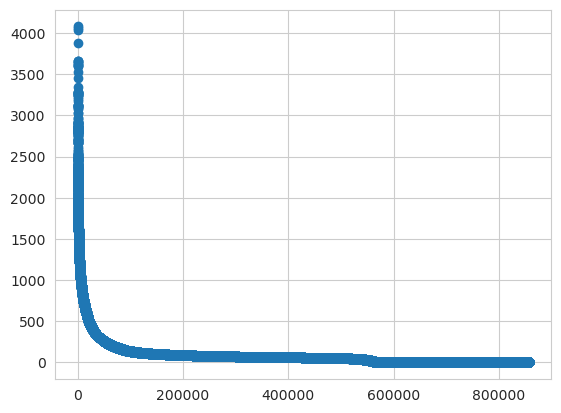

In [67]:
plt.scatter(np.arange(len(vals)),vals)

In [69]:
(vals < 100).mean()

0.8132935226714091

In [29]:
print(y1_train.max())
print(y2_train.max())
print(y3_train.max())
print(y4_train.max())
print(y5_train.max())
print(y6_train.max())

298.0
375.0
763.0
1902.0
2852.0
4080.0
